In [1]:
#using Distributed
#@everywhere using MambaModels
using MambaModels
gr(size=(400,400))

# Data
line = Dict{Symbol, Any}()

howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [2]:
df2 = filter(row -> row[:age] >= 18, df);
mean_weight = mean(df2[:weight])
df2[:weight_c] = convert(Vector{Float64}, df2[:weight]) .- mean_weight ;
line[:x] = convert(Array{Float64,1}, df2[:weight_c]);
line[:y] = convert(Array{Float64,1}, df2[:height]);
line[:xmat] = convert(Array{Float64,2}, [ones(length(line[:x])) line[:x]])

352×2 Array{Float64,2}:
 1.0    2.83512
 1.0   -8.50468
 1.0  -13.1256 
 1.0    8.05143
 1.0   -3.71361
 1.0   18.0021 
 1.0   -6.74701
 1.0   10.4895 
 1.0  -10.1206 
 1.0    9.49725
 ⋮             
 1.0    2.89182
 1.0   -5.58468
 1.0   -3.94041
 1.0   -4.16721
 1.0    2.04133
 1.0  -10.7443 
 1.0    7.17259
 1.0    9.07201
 1.0    7.54114

Model Specification

In [3]:
model = Model(
  y = Stochastic(1,
    (xmat, beta, s2) -> MvNormal(xmat * beta, sqrt(s2)),
    false
  ),
  beta = Stochastic(1, () -> MvNormal([178, 0], [sqrt(10000), sqrt(100)])),
  s2 = Stochastic(() -> Uniform(0, 50))
)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2:
A monitored node of type "ScalarStochastic"
NaN


Initial Values

In [4]:
inits = [
  Dict{Symbol, Any}(
    :y => line[:y],
    :beta => [rand(Normal(178, 100)), rand(Normal(0, 10))],
    :s2 => rand(Uniform(0, 50))
  )
  for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>[19.4441, 1.80296],:y=>[151.765, 139.7, 136.525, 156.845, 145.415, 163.83, 149.225, 168.91, 147.955, 165.1  …  156.21, 160.655, 146.05, 156.21, 152.4, 162.56, 142.875, 162.56, 156.21, 158.75],:s2=>5.26772) 
 Dict(:beta=>[93.516, 12.7415],:y=>[151.765, 139.7, 136.525, 156.845, 145.415, 163.83, 149.225, 168.91, 147.955, 165.1  …  156.21, 160.655, 146.05, 156.21, 152.4, 162.56, 142.875, 162.56, 156.21, 158.75],:s2=>10.4053)  
 Dict(:beta=>[248.821, -20.7691],:y=>[151.765, 139.7, 136.525, 156.845, 145.415, 163.83, 149.225, 168.91, 147.955, 165.1  …  156.21, 160.655, 146.05, 156.21, 152.4, 162.56, 142.875, 162.56, 156.21, 158.75],:s2=>19.5718)

Tuning Parameters

In [5]:
scale1 = [0.5, 0.25]
summary1 = identity
eps1 = 0.5

scale2 = 0.5
summary2 = x -> [mean(x); sqrt(var(x))]
eps2 = 0.1

0.1

Define sampling scheme

In [6]:
scheme = [
  Mamba.NUTS([:beta]),
  Mamba.Slice([:s2], 10)
]

setsamplers!(model, scheme)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2:
A monitored node of type "ScalarStochastic"
NaN


MCMC Simulation

In [7]:
chn = mcmc(model, line, inits, 10000, burnin=1000, chains=3)

MCMC Simulation of 10000 Iterations x 3 Chains...

Chain 1:   0% [0:00:10 of 0:00:10 remaining]
Chain 1:  10% [0:00:03 of 0:00:04 remaining]
Chain 1:  20% [0:00:03 of 0:00:04 remaining]
Chain 1:  30% [0:00:03 of 0:00:04 remaining]
Chain 1:  40% [0:00:02 of 0:00:04 remaining]
Chain 1:  50% [0:00:02 of 0:00:04 remaining]
Chain 1:  60% [0:00:02 of 0:00:04 remaining]
Chain 1:  70% [0:00:01 of 0:00:04 remaining]
Chain 1:  80% [0:00:01 of 0:00:04 remaining]
Chain 1:  90% [0:00:00 of 0:00:04 remaining]
Chain 1: 100% [0:00:00 of 0:00:05 remaining]

Chain 2:   0% [0:00:02 of 0:00:02 remaining]
Chain 2:  10% [0:00:04 of 0:00:04 remaining]
Chain 2:  20% [0:00:03 of 0:00:04 remaining]
Chain 2:  30% [0:00:03 of 0:00:04 remaining]
Chain 2:  40% [0:00:03 of 0:00:04 remaining]
Chain 2:  50% [0:00:02 of 0:00:04 remaining]
Chain 2:  60% [0:00:02 of 0:00:04 remaining]
Chain 2:  70% [0:00:01 of 0:00:04 remaining]
Chain 2:  80% [0:00:01 of 0:00:04 remaining]
Chain 2:  90% [0:00:00 of 0:00:04 remaining]
Cha

Object of type "ModelChains"

Iterations = 1001:10000
Thinning interval = 1
Chains = 1,2,3
Samples per chain = 9000

[25.5685 154.804 0.866963; 24.4271 154.738 0.932954; … ; 26.0408 154.938 0.912613; 24.793 154.949 0.960319]

[25.9447 154.631 0.961961; 25.7941 154.698 0.964201; … ; 24.3788 154.833 0.896174; 24.8773 154.833 0.896174]

[31.4405 154.182 0.813885; 33.7544 154.182 0.813885; … ; 28.3997 154.513 0.955506; 26.949 154.407 0.892155]

Show draws summary

In [8]:
describe(chn)

Iterations = 1001:10000
Thinning interval = 1
Chains = 1,2,3
Samples per chain = 9000

Empirical Posterior Estimates:
            Mean          SD        Naive SE        MCSE        ESS   
     s2  26.16646298 1.989590871 0.01210826445 0.01987239660 9000.0000
beta[1] 154.59494575 0.277556437 0.00168915468 0.00416641155 4437.9078
beta[2]   0.90550995 0.042071173 0.00025603701 0.00033580071 9000.0000

Quantiles:
            2.5%       25.0%        50.0%       75.0%       97.5%  
     s2  22.5468681  24.7852299  26.05427036  27.4318317  30.372761
beta[1] 154.0638913 154.4059729 154.59368666 154.7807843 155.154942
beta[2]   0.8228201   0.8769806   0.90558667   0.9337842   0.987952



Convert to MCMCChains.Chains object

In [9]:
chn2 = MCMCChains.Chains(chn.value, String.(chn.names))

Object of type Chains, with data of type 9000×3×3 Array{Float64,3}

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 9000
parameters        = s2, beta[1], beta[2]

Summary Statistics

│ Row │ parameters │ mean    │ std       │ naive_se    │ mcse        │ ess     │
│     │ Symbol     │ Float64 │ Float64   │ Float64     │ Float64     │ Float64 │
├─────┼────────────┼─────────┼───────────┼─────────────┼─────────────┼─────────┤
│ 1   │ beta[1]    │ 154.595 │ 0.277556  │ 0.00168915  │ 0.00416641  │ 4437.91 │
│ 2   │ beta[2]    │ 0.90551 │ 0.0420712 │ 0.000256037 │ 0.000335801 │ 15696.6 │
│ 3   │ s2         │ 26.1665 │ 1.98959   │ 0.0121083   │ 0.0198724   │ 10023.7 │

Describe the MCMCChains

In [10]:
MCMCChains.describe(chn2)

2-element Array{MCMCChains.ChainDataFrame,1}

Summary Statistics

│ Row │ parameters │ mean    │ std       │ naive_se    │ mcse        │ ess     │
│     │ Symbol     │ Float64 │ Float64   │ Float64     │ Float64     │ Float64 │
├─────┼────────────┼─────────┼───────────┼─────────────┼─────────────┼─────────┤
│ 1   │ beta[1]    │ 154.595 │ 0.277556  │ 0.00168915  │ 0.00416641  │ 4437.91 │
│ 2   │ beta[2]    │ 0.90551 │ 0.0420712 │ 0.000256037 │ 0.000335801 │ 15696.6 │
│ 3   │ s2         │ 26.1665 │ 1.98959   │ 0.0121083   │ 0.0198724   │ 10023.7 │

Quantiles

│ Row │ parameters │ 2.5%    │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64 │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼─────────┼──────────┼──────────┼──────────┼──────────┤
│ 1   │ beta[1]    │ 154.064 │ 154.406  │ 154.594  │ 154.781  │ 155.155  │
│ 2   │ beta[2]    │ 0.82282 │ 0.876981 │ 0.905587 │ 0.933784 │ 0.987952 │
│ 3   │ s2         │ 22.5469 │ 24.7852  │ 26.0543  │ 27.4318 

Plot chn2

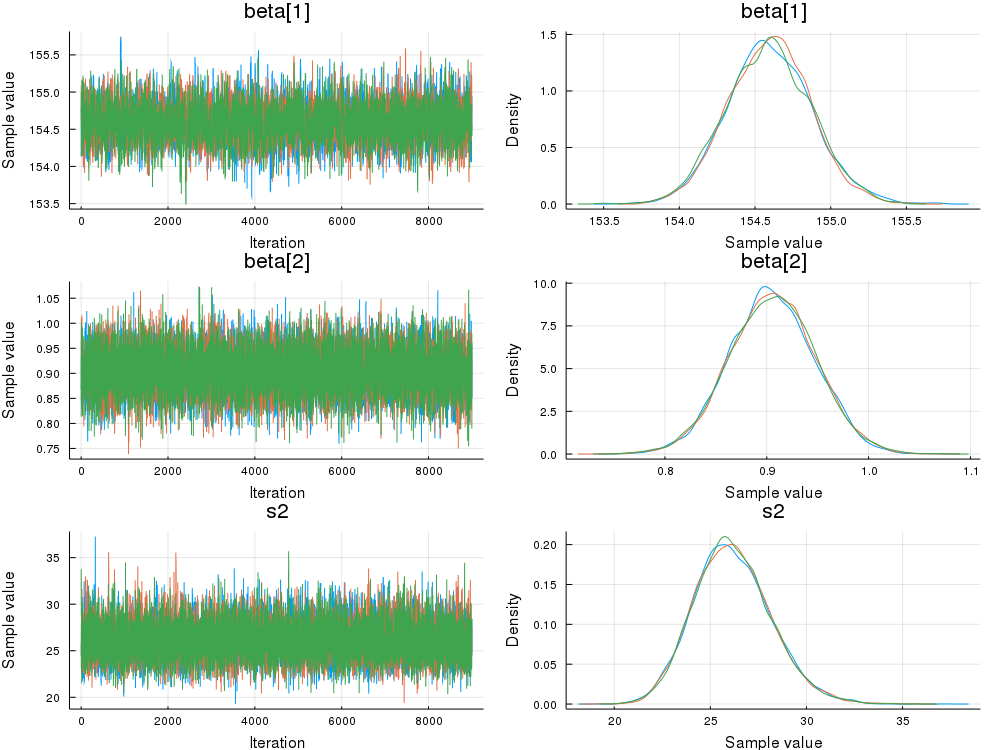

In [11]:
MCMCChains.plot(chn2)

End of `04/m4.1m.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*